# 7. Remedios y métodos robustos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import statsmodels.api as sm
from statsmodels.robust.norms import HuberT, TukeyBiweight

from sklearn.utils import resample

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
path = '../Data/'

X = np.load(path + 'X_def.dat', allow_pickle= True)
B = np.load(path + 'B_def.dat', allow_pickle= True)
Y = np.load(path + 'Y_def.dat', allow_pickle= True)

In [4]:
result =  sm.load(path + 'ols_def_results.pickle')

In [5]:
with open("../Data/regressor_columns_def.pickle", "rb") as fp:   #Pickling
...   regressor_columns_def = pickle.load(fp)

In [17]:
df = pd.read_csv(path+'hour-processed2.csv', delimiter=',', index_col=0)

## 7.1 HAC: Correcciones para autocorrelación

En un modelo de regresión lineal clásica (OLS), se asume que los errores $\varepsilon_i$ tienen varianza constante y son independientes entre sí. Cuando este supuesto no se cumple (es decir, hay heterocedasticidad y autocorrelación, como es nuestro caso), los coeficientes estimados $ \hat{\beta} $ siguen siendo insesgados,  
pero sus errores estándar son incorrectos, lo que invalida:

- Las pruebas t y F (significancia estadística)
- Los intervalos de confianza
- La inferencias sobre los coeficientes

Para corregir este problema, se usan errores estándar robustos a la heterocedasticidad y autocorrelación, conocidos como correcciones HAC (Heteroskedasticity and Autocorrelation Consistent).

El estimador más conocido es el Newey–West (1987). El método HAC:

1. Calcula la autocovarianza entre residuos en distintos rezagos.

2. Pondera esas autocovarianzas: mayor peso a rezagos pequeños, menor a rezagos grandes.

3. Construye una matriz de covarianza robusta, que reemplaza a la de OLS.

4. Recalcula los errores estándar usando esta matriz corregida.

Estos pasos nos otorgan errores estándar corregidos, sin afectar los coeficientes, los cuales serán los mismos que OLS. La matriz de covarianza HAC (Newey–West) es:

$$
\widehat{V}_{HAC} = (X'X)^{-1}(\sum^q_{k=-q}{w_k\Gamma_k})(X'X)^{-1}
$$

Donde:
* $\Gamma_k$: autocovarianza muestral de los residuos en rezago k
* q = número de rezagos incluidos (parámetro maxlags)
* $w_k$: pesos tipo *Bartlett kernel*

$$w_k = 1 - \frac{|k|}{q+1}$$

Los rezagos más antiguos recibirán un peso cercano a 0, ya que se consideran menos relevantes.

---
En base a lo anterior, calculamos nuestros modelos robustos, sabiendo que los coeficientes no cambiaran, la afectación principal será al error estandar.

In [8]:
print("\nModelos con corrección robusta a heterocedasticidad y autocorrelación: HAC")
nw_results = result.get_robustcov_results(
    cov_type='HAC',
    maxlags=24
)
print(f"\n=== Resultados con HAC ===")
nw_results.summary(yname='cnt', xname=['const'] + regressor_columns_def)


Modelos con corrección robusta a heterocedasticidad y autocorrelación: HAC

=== Resultados con HAC ===


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     403.1
Date:                Sun, 30 Nov 2025   Prob (F-statistic):               0.00
Time:                        15:06:53   Log-Likelihood:            -1.0606e+05
No. Observations:               17379   AIC:                         2.122e+05
Df Residuals:                   17362   BIC:                         2.123e+05
Df Model:                          16                                         
Covariance Type:                  HAC                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          129.1644      4.367     29.579      0.000     120.605     137.724
temp            44.6337      2.659     16.788      0.000      39.423      49.845
hum            -12.6139      1.709     -7.381      0.000     -15.963      -9.264
windspeed       -3.6435      1.291     -2.822      0.005      -6.174      -1.113
yr              42.8581      1.240     34.555      0.000      40.427      45.289
hr_sin         -59.1737      1.581    -37.427      0.000     -62.273     -56.075
hr_cos         -52.5558      1.498    -35.083      0.000     -55.492     -49.620
weekday_sin     -2.3121      1.204     -1.920      0.055      -4.672       0.048
day_cos         -3.7261      1.137     -3.278      0.001      -5.954      -1.498
mnth_sin        -7.2971      2.986     -2.444      0.015     -13.150      -1.444
holiday        -28.6042      9.417     -3.037      0.002     -47.063     -10.146
rush_hour      159.2708      5.729     27.801      0.000     148.041     170.500
season_2        45.1455      4.473     10.093      0.000      36.379      53.913
season_3        18.8102      7.084      2.655      0.008       4.924      32.696
season_4        54.6313      5.837      9.360      0.000      43.191      66.072
weathersit_2   -11.7924      2.553     -4.619      0.000     -16.797      -6.788
weathersit_3   -66.6204      5.370    -12.405      0.000     -77.147     -56.094
==============================================================================
Omnibus:                     2110.243   Durbin-Watson:                   0.728
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3994.669
Skew:                           0.790   Prob(JB):                         0.00
Kurtosis:                       4.738   Cond. No.                         10.5
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 24 lags and without small sample correction
"""

## 7.2 RLM: Modelos robustos con funciones Huber/Tukey

En muchos datasets reales (como el analizado), existen:

- Outliers estructurales (casas atípicamente grandes o pequeñas).  
- Errores de medición o distribuciones asimétricas.

La Regresión Robusta (RLM) busca reducir el efecto de estos puntos extremos, de modo que el modelo capture mejor la tendencia central de los datos.

### 7.2.1 Función de pérdida de Huber

La función de Huber combina las ventajas de OLS y de la regresión absoluta (L1):

$$
\rho(u) =
\begin{cases}
\frac{1}{2}u^2 & \text{si } |u| \leq c \\
c(|u| - \frac{1}{2}c) & \text{si } |u| > c
\end{cases}
$$

Donde:
- $u = \frac{y_i - \hat{y}_i}{\sigma}$ es el residuo estandarizado.  
- $c$ es un parámetro de sensibilidad (típicamente \(c = 1.345\)).

De esta forma para residuos pequeños, Huber se comporta igual que OLS (cuadrático). Pero, para residuos grandes, estos se penalizan linealmente (como L1), reduciendo la influencia de outliers.

A continuación calculamos nuestro modelo con Huber:

In [10]:
# Ajustar modelo RLM con Huber (Regresión Lineal Robusta)
rlm_model = sm.RLM(Y, X, M=HuberT())  
rlm_results = rlm_model.fit()

print(rlm_results.summary(xname = ['const'] + regressor_columns_def))

                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                17379
Model:                            RLM   Df Residuals:                    17362
Method:                          IRLS   Df Model:                           16
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 30 Nov 2025                                         
Time:                        15:08:52                                         
No. Iterations:                    19                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          124.6148      2.306     54.037   

---
Por otra parte, la función de Tukey o biweight penaliza los residuos de forma suave, y llega incluso a eliminar completamente la influencia de los puntos demasiado lejanos.

$$
\rho(u) =
\begin{cases}
\frac{c^2}{6} \left[ 1 - \left( 1 - \left(\frac{u}{c}\right)^2 \right)^3 \right] & \text{si } |u| \leq c \\
\frac{c^2}{6} & \text{si } |u| > c
\end{cases}
$$

Donde:

- $u = \frac{y_i - \hat{y}_i}{\sigma}$ es el residuo estandarizado.  
- $c$ es un parámetro de corte que determina qué tan agresivo es el recorte de outliers (típicamente $c = 4.685$).


In [12]:
# Ajustar modelo RLM con Tukey (Regresión Lineal Robusta)
tukey_model = sm.RLM(Y, X, M=TukeyBiweight()) 
tukey_results = tukey_model.fit()

print(tukey_results.summary(xname = ['const'] + regressor_columns_def))

                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                17379
Model:                            RLM   Df Residuals:                    17362
Method:                          IRLS   Df Model:                           16
Norm:                   TukeyBiweight                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 30 Nov 2025                                         
Time:                        15:09:27                                         
No. Iterations:                    50                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          121.7857      2.208     55.160   

Observamos que aunque encontramos una leve variación en los pesos de los coeficiente, siguen manteniendo significancia (con excepción del intercepto).

In [15]:
comparison_params = pd.DataFrame({
    'Variable': ['const'] + regressor_columns_def,
    'OLS': result.params,
    'Huber': rlm_results.params,
    'Tukey': tukey_results.params
})

comparison_params

,Variable,OLS,Huber,Tukey
0,const,129.164373,124.614844,121.785671
1,temp,44.633725,40.468812,38.876340
2,hum,-12.613897,-11.271741,-10.681757
3,windspeed,-3.643515,-3.452098,-3.357206
4,yr,42.858051,33.321335,27.687102
5,hr_sin,-59.173684,-60.373921,-60.491425
6,hr_cos,-52.555817,-47.091119,-44.890279
7,weekday_sin,-2.312107,-4.388344,-5.010446
8,day_cos,-3.726146,-2.704092,-2.291245
9,mnth_sin,-7.297101,-4.040379,-1.728356


---
Finalmente, analizamos el peso asignado a los outlier, de acuerdo al tipo de metodo. Vemos que OLS asigna el mismo peso a cada observación, pero huber y tukey asignan menos peso según este se va alejando de la media. En el caso de Tukey, vemos que esta inflencia llega a ser nula, y empieza a disminuir la influencia suavemente desde el comienzo. Huber en cambio, toma cierta distancia antes de empezar a afectar la influencia, sin llegar a eliminarla completamente.

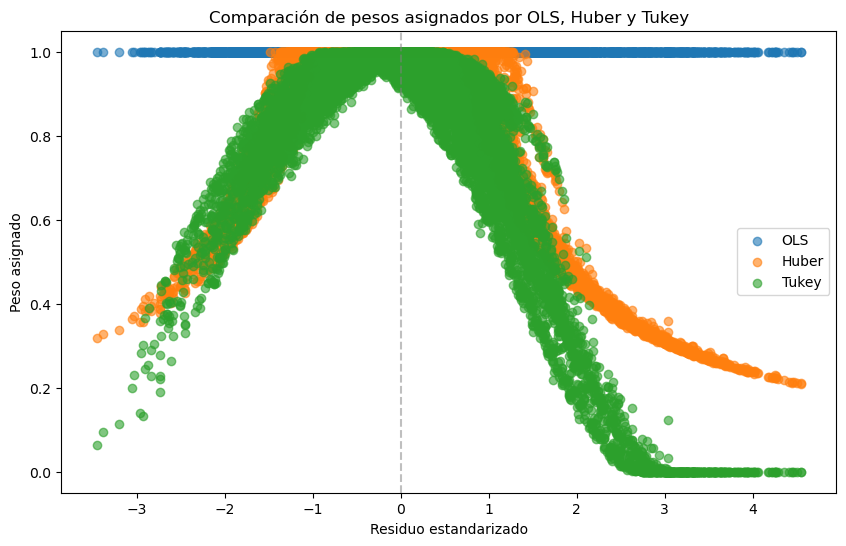

In [16]:

# Modelo RLM con Huber
weights_huber = rlm_results.weights

# Modelo RLM con Tukey (biweight)
weights_tukey = tukey_results.weights

# Residuo estandarizado
resid_std = (Y.flatten() - result.fittedvalues) / np.std(result.resid)

# Construir DataFrame comparativo
weights_df = pd.DataFrame({
    'Residuo estandarizado': resid_std,
    'Peso_Huber': weights_huber,
    'Peso_Tukey': weights_tukey,
    'Peso_OLS': 1  # OLS asigna peso uniforme
})

# Visualización
plt.figure(figsize=(10,6))
plt.scatter(weights_df['Residuo estandarizado'], weights_df['Peso_OLS'], label='OLS', alpha=0.6)
plt.scatter(weights_df['Residuo estandarizado'], weights_df['Peso_Huber'], label='Huber', alpha=0.6)
plt.scatter(weights_df['Residuo estandarizado'], weights_df['Peso_Tukey'], label='Tukey', alpha=0.6)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
plt.title("Comparación de pesos asignados por OLS, Huber y Tukey")
plt.xlabel("Residuo estandarizado")
plt.ylabel("Peso asignado")
plt.legend()
plt.show()

## 7.3 Bootstrap

Bootstrap se aprovecha de la ley de los grandes número para estimar los coeficientes y estadísticos del modelo sin asumir una distribución teórica para los datos.

Consiste en una serie de muestreos aleatorios con reemplazo del set de entrenamiento, una gran cantidad de veces (n > 1000). Si los datos observados son una buena representación de la población, entonces remuestrear con reemplazo de ellos puede simular nuevas "muestras" de esa población.

En cada iteración se ajusta un modelo de acuerdo al muestreo realizado. Los coeficientes de cada iteración se guardan. Tras finalizar, el coeficiente correspondiente de cada variable corresponderá al promedio de los n coeficientes obtenidos y el error estandar será igual a la desviación estandar de cada variable. 

 La colección de estimadores:
   $$
   \{ \hat{\theta}^*_1, \hat{\theta}^*_2, ..., \hat{\theta}^*_B \}
   $$
   representa una aproximación empírica a la distribución del estimador.

**Error estándar (EE):**
 $$
 SE(\hat{\theta}) = \sqrt{\frac{1}{B-1} \sum_{b=1}^B \left(\hat{\theta}^*_b - \overline{\hat{\theta}^*}\right)^2 }
 $$
- **Intervalo de confianza (95%):**
 percentiles 2.5% y 97.5% de la distribución bootstrap.

In [41]:
# ------------------------------------------------------------
# 1. BLOCK BOOTSTRAP TEMPORAL
# ------------------------------------------------------------

def block_bootstrap_indices(n_obs, block_size, n_boot):
    block_starts = np.arange(0, n_obs - block_size)
    boot_samples = []

    for _ in range(n_boot):
        n_blocks = int(np.ceil(n_obs / block_size))
        sampled_indices = []

        for _ in range(n_blocks):
            start = np.random.choice(block_starts)
            block = np.arange(start, start + block_size)
            sampled_indices.append(block)

        sampled_indices = np.concatenate(sampled_indices)[:n_obs]
        boot_samples.append(sampled_indices)

    return boot_samples

# ------------------------------------------------------------
# 2. OLS CON BLOCK BOOTSTRAP
# ------------------------------------------------------------

def temporal_block_bootstrap_ols(df, target, features, block_size=48, n_boot=2000):
    """
    Regresión OLS con block bootstrap temporal.
    """
    df = df.reset_index(drop=True)
    
    X_raw = df[features].copy()

    # Columna explícita de 1's
    X = pd.concat([pd.Series(1, index=X_raw.index, name="const"), X_raw], axis=1)

    y = df[target].values
    n = len(df)

    bootstrap_indices = block_bootstrap_indices(n, block_size, n_boot)

    coef_list = []

    for idx in bootstrap_indices:
        Xb = X.iloc[idx]  
        yb = y[idx]        

        model = sm.OLS(yb, Xb).fit()
        coef_list.append(model.params.values)

    coef_array = np.array(coef_list)

    coef_summary = pd.DataFrame({
        "variable": ["const"] + features,
        "coef_mean": coef_array.mean(axis=0),
        "coef_std": coef_array.std(axis=0),
        "ci_2.5%": np.percentile(coef_array, 2.5, axis=0),
        "ci_97.5%": np.percentile(coef_array, 97.5, axis=0),
    })

    return coef_summary, coef_array

In [42]:
coef_summary, coef_array = temporal_block_bootstrap_ols(
    df,
    target='cnt',
    features=regressor_columns_def,
    block_size=48,   # tamaño de bloque = 2 días (24h × 2)
    n_boot=2000
)

print("\n=== Bootstrap Coefficients Summary ===\n")
print(coef_summary)


=== Bootstrap Coefficients Summary ===

        variable   coef_mean  coef_std     ci_2.5%    ci_97.5%
0          const  129.551486  5.347358  119.076481  139.451054
1           temp   44.481277  3.412309   37.903269   50.925165
2            hum  -12.655237  1.874868  -16.331340   -9.066258
3      windspeed   -3.551541  1.274631   -6.088109   -1.128060
4             yr   42.951971  1.542883   39.939950   45.913914
5         hr_sin  -59.363866  2.003450  -63.534614  -55.458764
6         hr_cos  -52.596568  1.809539  -56.113513  -49.016243
7    weekday_sin   -2.238316  1.362200   -4.960747    0.371074
8        day_cos   -3.593134  1.382722   -6.319808   -0.822236
9       mnth_sin   -7.686178  3.835194  -15.233686   -0.353352
10       holiday  -28.528464  9.752666  -47.915270  -10.624231
11     rush_hour  160.105369  6.962755  146.835187  173.508584
12      season_2   44.867781  5.654683   33.920306   55.506339
13      season_3   17.929706  8.443234    1.471832   34.244180
14      season

---
Analizando la distribución de cada coeficiente y comparandolo con el ols original, observamos resultados bastante similares y una distribución aproximadamente normal en la mayoría de los coeficientes.

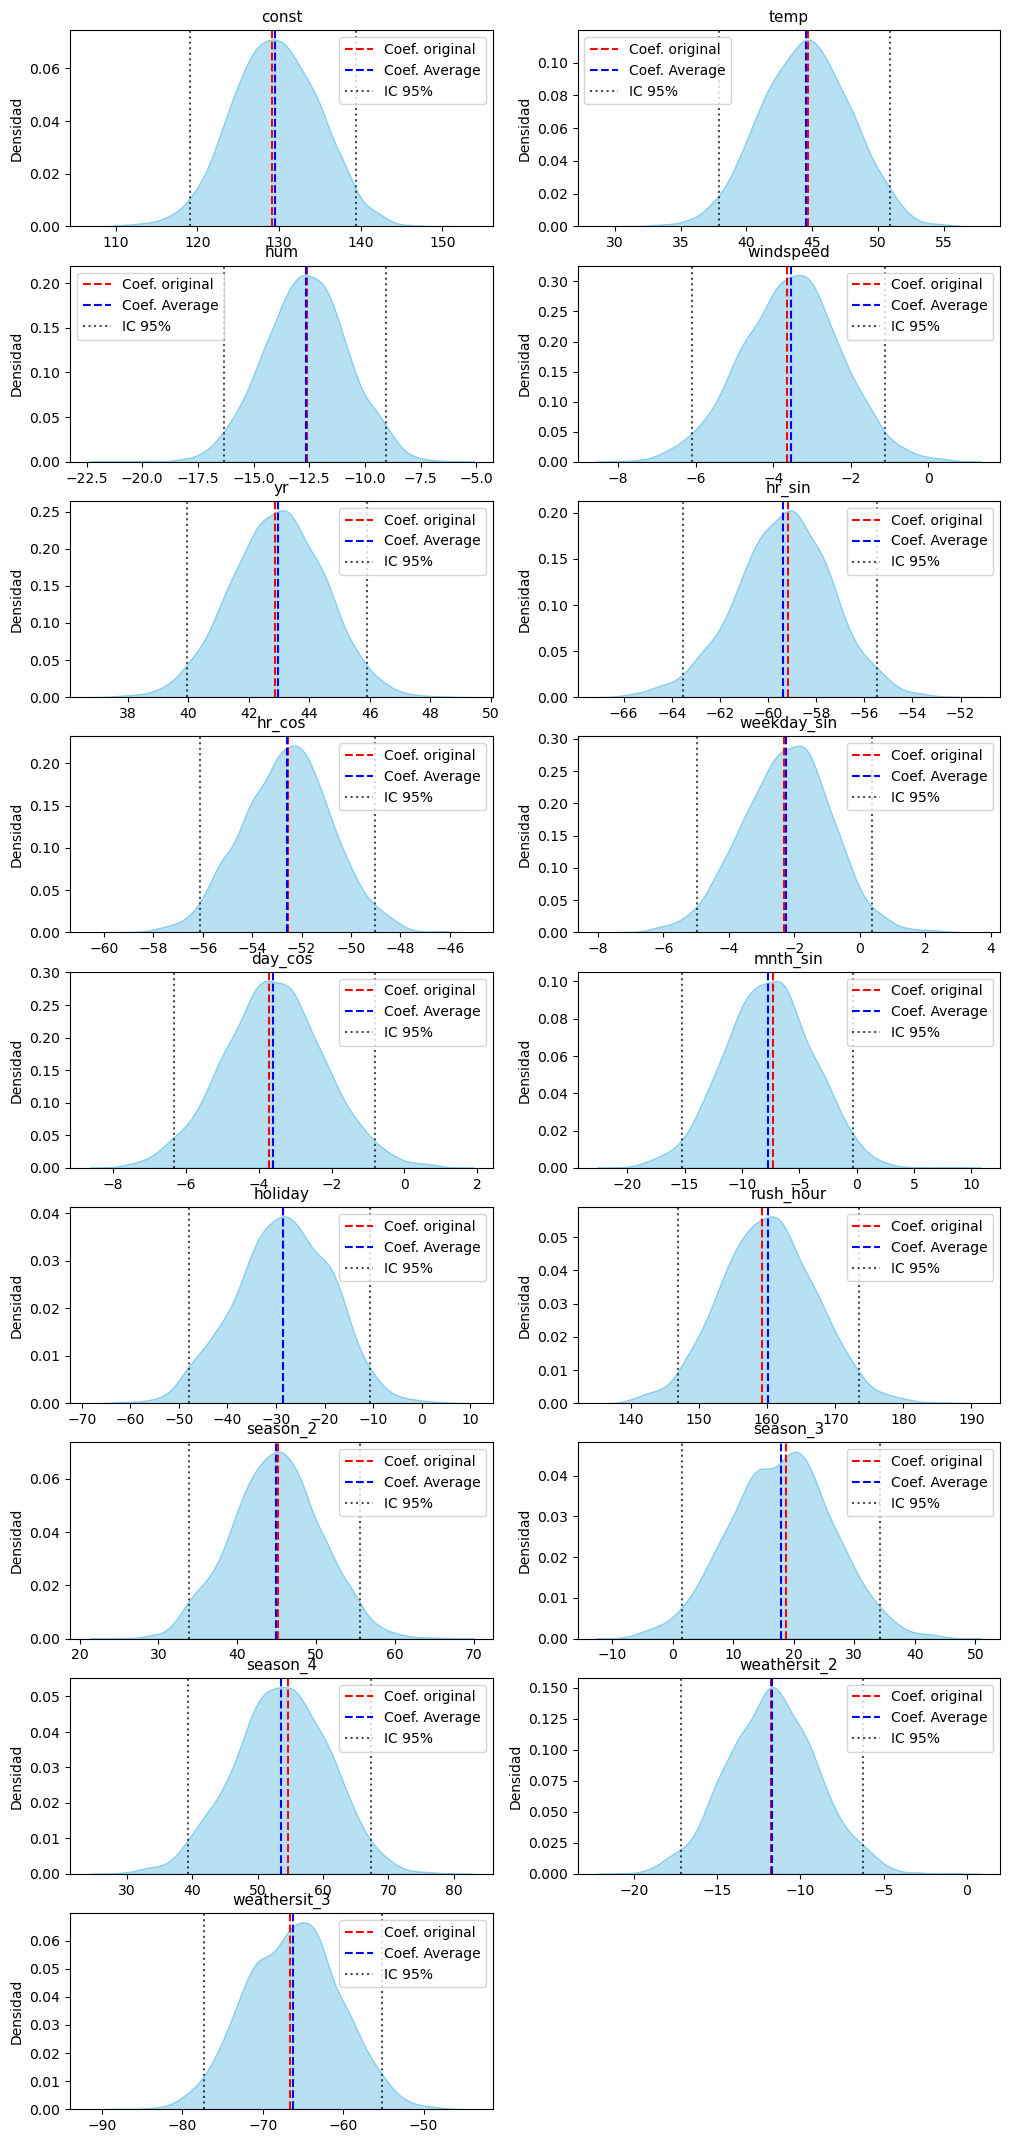

In [50]:

n_vars = len(coef_summary['variable'])
n_cols = 2
n_rows = int(np.ceil(n_vars / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 3))
axes = axes.flatten()

# --- Graficar distribuciones ---
for i, col in enumerate(coef_summary['variable']):
    sns.kdeplot(coef_array[:,i], fill=True, color='skyblue', alpha=0.6, ax=axes[i])
    
    # Línea del coeficiente original
    axes[i].axvline(x=nw_results.params[i], color='red', linestyle='--', label='Coef. original')
    axes[i].axvline(x=coef_summary['coef_mean'].iloc[i], color='blue', linestyle='--', label='Coef. Average')
    
    # Intervalo de confianza 95%
    ci_lower, ci_upper = coef_summary['ci_2.5%'].iloc[i], coef_summary['ci_97.5%'].iloc[i]
    axes[i].axvline(ci_lower, color='black', linestyle=':', alpha=0.7, label='IC 95%')
    axes[i].axvline(ci_upper, color='black', linestyle=':', alpha=0.7)
    
    axes[i].set_title(f"{col}", fontsize=11)
    axes[i].set_ylabel("Densidad")
    axes[i].legend()

# --- Eliminar subplots vacíos ---
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

## 7.4 Tabla Comparativa

A continuación, mostramos las tablas comparativas entre los modelos obtenidos para los estadisticos principales.

### 7.4.1 Error Estándar

Observamos que el metodo Bootstrap entrega en la mayoría de los casos el error estándar más alto, similares a los arrojados por HAC. Esto nos lleva a pensar que Huber subestima un poco el error estándar de los errores, probablemente por una asunción erronea como puede ser normalidad o homocedasticidad.

In [55]:
comparison_se = pd.DataFrame({
    'Variables': ['const'] + regressor_columns_def,
    'HAC': nw_results.bse,
    'Huber': rlm_results.bse,
    'Bootstrap_SE': coef_summary['coef_std']
})
comparison_se.set_index('Variables', inplace=True)

comparison_se

,HAC,Huber,Bootstrap_SE
Variables,,,
const,4.366757,2.306104,5.347358
temp,2.658614,1.247927,3.412309
hum,1.708887,0.934038,1.874868
windspeed,1.291238,0.744251,1.274631
yr,1.240302,0.696747,1.542883
hr_sin,1.581047,0.800877,2.003450
hr_cos,1.498033,0.777959,1.809539
weekday_sin,1.204137,0.697622,1.362200
day_cos,1.136797,0.690618,1.382722


### 7.4.2 Amplitud de intervalos de confianza

In [58]:
HAC_ci = nw_results.conf_int(alpha=0.05)

HAC_width = HAC_ci[:,1] - HAC_ci[:,0]

HAC_width

array([17.11856718, 10.42230142,  6.69918236,  5.06191308,  4.86223315,
        6.19802146,  5.87259082,  4.72046057,  4.45647154, 11.70572841,
       36.91732213, 22.4589947 , 17.5340478 , 27.77261911, 22.88125247,
       10.00849094, 21.05297369])

In [60]:
rlm_ci = rlm_results.conf_int(alpha=0.05)

rlm_width = rlm_ci[:,1] - rlm_ci[:,0]

rlm_width

array([ 9.0397599 ,  4.89178379,  3.6613631 ,  2.91741048,  2.73119973,
        3.13937885,  3.04954294,  2.73462692,  2.70717144,  5.97659633,
       16.34510262,  6.39488453,  9.85116018, 15.42750992, 12.66266161,
        6.702753  , 11.27571102])

In [56]:
bootstrap_width = coef_summary['ci_97.5%'] - coef_summary['ci_2.5%']

bootstrap_width

0     20.374572
1     13.021896
2      7.265083
3      4.960049
4      5.973964
5      8.075850
6      7.097270
7      5.331821
8      5.497572
9     14.880334
10    37.291040
11    26.673397
12    21.586033
13    32.772347
14    28.076478
15    10.936723
16    22.163935
dtype: float64

In [61]:
comparison_ICwidth = pd.DataFrame({
    'Variables': ['const'] + regressor_columns_def,
    'HAC': HAC_width,
    'RLM': rlm_width,
    'Bootstrap': bootstrap_width
})

comparison_ICwidth.set_index('Variables', inplace=True)

comparison_ICwidth

,HAC,RLM,Bootstrap
Variables,,,
const,17.118567,9.039760,20.374572
temp,10.422301,4.891784,13.021896
hum,6.699182,3.661363,7.265083
windspeed,5.061913,2.917410,4.960049
yr,4.862233,2.731200,5.973964
hr_sin,6.198021,3.139379,8.075850
hr_cos,5.872591,3.049543,7.097270
weekday_sin,4.720461,2.734627,5.331821
day_cos,4.456472,2.707171,5.497572


En cambio, Boostrap entrega en su mayoría el intervalo de confianza más amplio. Esto podría indicar que la presunción de normalidad podría no ser correcta, ya que Bootstrap entrega resultados más emperícos, sin necesidad de asumir una distribución de los errores.

### 7.4.3 Comparación de coeficientes

In [62]:
comparison_coeff = pd.DataFrame({
    'Variables': ['const'] + regressor_columns_def,
    'HAC': nw_results.params,
    'RLM': rlm_results.params,
    'Bootstrap': coef_summary['coef_mean']
})

comparison_coeff.set_index('Variables', inplace=True)

comparison_coeff

,HAC,RLM,Bootstrap
Variables,,,
const,129.164373,124.614844,129.551486
temp,44.633725,40.468812,44.481277
hum,-12.613897,-11.271741,-12.655237
windspeed,-3.643515,-3.452098,-3.551541
yr,42.858051,33.321335,42.951971
hr_sin,-59.173684,-60.373921,-59.363866
hr_cos,-52.555817,-47.091119,-52.596568
weekday_sin,-2.312107,-4.388344,-2.238316
day_cos,-3.726146,-2.704092,-3.593134


Finalmente, al comparar los coeficientes, vemos que bootstrap arroja resultados muy similares a HAC. Los coeficientes arrojados por OLS no dependen de supuestos como normalidad o homocedasticidad, por lo que tiene sentido que sea similar a lo entregado por Bootstrap. RLM presenta diferencias más notables, donde las mayores la vemos en el caso de la variable 'yr', 'rush_hour' y 'season_2'.

Esto puede deberse a que, al eliminar influencia de outliers en estas variables, RLM le da menos significancia que la que le da OLS.